In [1]:
# import ROOT
import numpy as np
from glob import glob
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib

# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

import json
import os,sys

from auxiliaryFunctions import *
from calibrationFilesHelper import *
# from calibrationFilesHelperROOT import *

# import tensorflow

sys.path.insert(1, '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/EventReader/share')
# sys.path.insert(1, '/eos/user/m/mhufnage/SWAN_projects/XTalk/')



# Load files and Paths

In [2]:
# MC
# filename    = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/source/EventReader/share/file002.npz' 
# dataset     = np.load(filename,allow_pickle=True) # npz file contains arrays of dicts.

# Data
resultFiles     = ['results_analysis_cluster.npz', 'results_analysis_711roi.npz']
supTitleString  = ['TopoCluster', '7x11 EMB2 ROI']
confFiles       = ['conf_analysis_cluster.npz','conf_analysis_711.npz']
clusNames       = ['clusters', '711_roi']
eventsBlockList = [-99999999]

datasetPath ='/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_getOFCandRamp/dataMinBias_getOFCandRamp_part*.npz'
# datasetPath ='/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_getDSPThrs/dataMinBias_getDSPThrs_part*.npz'
# datasetPath ='/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_janFix/dataMinBias_janFix_part*.npz'

# Result file to analysis
# resultFileAlias   = 'flipped_timeThres'
resultFileAlias   = 'timeThres'

# Helper
path        = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/EventReader/share/'
fDict       = open(path+'dictCaloByLayer.json')
caloDict    = json.load(fDict)

calibPathLAr = '/eos/user/m/mhufnage/scripts_lxplus/calibration/calib_LAr/'

print("constants loaded succesfully.")

constants loaded succesfully.


## Calibration constants:  \*.root $\rightarrow$ *.npz
- Run to generate the \*.npz files for the calibration constants, from their root files.

In [ ]:
from calibrationFilesHelperROOT import *

# OFC
print("OFC...")
fileName = calibPathLAr+'LArCalib_OFC_r329542.root'
ofc_dict  = readOFCRootFile(fileName)

# PEDESTALS
print("PED...")
fileName = calibPathLAr+'LArCalib_ped_r329542.root'
ped_dict  = readPEDRootFile(fileName)

# MPMC
print("MPMC...")
fileName = calibPathLAr+'LArCalib_mphysovermcalib329542_athena22044.root'
mpmc_dict  = readMPMCRootFile(fileName)

# UAMEV
print("UAMEV...")
fileName = calibPathLAr+'LArCalib_dac2ua-ua2mev329542_athena22044.root'
uamev_dict = readUAMEVRootFile(fileName)

# RAMPS
fileName = calibPathLAr+'LArCalib_ramp329542_athena22044.root'
ramps_dict = readRAMPSRootFile(fileName)

## Load calibration constants from \*.npz
- Run to only load the calibration constants to memory.

In [3]:
ofc_dict = np.load('calibration/OFC_dict.npz',allow_pickle=True )['OFC'].tolist()
ped_dict = np.load('calibration/PED_dict.npz',allow_pickle=True )['PED'].tolist()
mpmc_dict = np.load('calibration/MPMC_dict.npz',allow_pickle=True )['MPMC'].tolist()
uamev_dict = np.load('calibration/UAMEV_dict.npz',allow_pickle=True )['UAMEV'].tolist()
ramps_dict = np.load('calibration/RAMPS_dict.npz',allow_pickle=True )['RAMPS'].tolist()

# A) Full data analysis: Digits and RawChannels

In [4]:
# chid = dataset['dataset'][1]['electrons']['el_0']['clusters']['cl_0'][cellInfoName]['channelId'][0]
import time

start = time.time()
evt_lim = 15

# resultFileAlias   = 'flipped_timeThres'
el_thrs             = [10] # GeV
nCellsChEta         = 5
nCellsChPhi         = 5
nCellsRawChEta      = 5
nCellsRawChPhi      = 5
clusNames           = ['711_roi', 'clusters'] #'clusters'
# calibTypes          = ['database', 'typical'] #'database'#'database' #'typical' # or 
calibTypes          = ['database','typical', 'dumper'] #'database'#'database' #'typical' # or 
# layerTimingEneThr   = [100, 100, 200, 100] # threshold for set timing to zero (MeV) -> Testing!
 
fileNames       = glob(datasetPath)#datasetPath

for calibType in calibTypes:
    print('Calibration type: {}'.format(calibType))
    for el_thr in el_thrs:
        print('Electron pt cut: {} GeV'.format(el_thr))
        for clusName in clusNames:
            print('Processing cluster: {}'.format(clusName))
            
            analysis   = ['digitsCluster', 
                        'digitsWindow',
                        'digitsClusterSize', 
                        'digitsWindowSize',
                        'channelEnergyCluster',
                        'channelEnergyWindow',
                        'channelTimeCluster',
                        'channelTimeWindow', 
                        'channelInfoCluster',
                        'channelInfoWindow',
                        'channelIdCluster',
                        'channelIdWindow',
                        'channelGainCluster',
                        'channelGainWindow',
                        'channelEffSigmaCluster',
                        'channelEffSigmaWindow',
                        'channelNoiseCluster',
                        'channelNoiseWindow',
                        'chDSPThrCluster',
                        'chDSPThrWindow',
                        # 'chOFCTimeOffset',
                        # 'chADC2MeV0',
                        # 'chADC2MeV1',
                        # 'chOFCa',
                        # 'chOFCb',

                        # Estimated values (using calib. constants)
                        'ACluster',
                        'AWindow',
                        'tauCluster',                        
                        'tauWindow',
                        'ECalibCluster',
                        'ECalibWindow',
                        'tauDSPCluster',
                        'tauDSPWindow',
                        'EDSPCalibCluster',
                        'EDSPCalibWindow',

                        'amplitudeCluster',
                        'amplitudeWindow',
                        'rawChTimeCluster',
                        'rawChTimeWindow',                  
                        'rawChInfoCluster',
                        'rawChInfoWindow',
                        'rawChIdCluster',
                        'rawChIdWindow',
                        'rawChGainCluster',
                        'rawChGainWindow',
                        'rawChDSPThrCluster',
                        'rawChDSPThrWindow'
                        ]

            results              = {key:{key1:[] for key1 in analysis} for key in caloDict["Layer"]}
            results[clusName]    = {'pt':[],'eta':[],'phi':[]} # Cluster and ROI data

            for file in fileNames:
                print(file)
                dataset     = np.load(file, allow_pickle=True)

                for evtn, ev in enumerate(dataset['dataset']): # for each event...
                    # print("Event number: {}".format(ev['eventNumber']))
                    if (ev['eventNumber'][0] in eventsBlockList):
                        print('Ignoring blocked event {}.'.format(ev['eventNumber']))
                        continue
                    if (evtn%100) == 0:
                        print("Event {}...".format(evtn))
                    # if evtn > evt_lim:
                    #     break

                    for elec in ev['electrons'].keys(): # for each electron in this event...
                #         print(ev['electrons'][elec]['pt'])
                        if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
                            continue
                        if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                            continue
                        
                        clusloop = ev['electrons'][elec][clusName]

                        for clus in clusloop.keys(): # for each cluster associated to that electron...
                            
                            results[clusName]['pt'].append(ev['electrons'][elec][clusName][clus]['pt'])
                            results[clusName]['eta'].append(ev['electrons'][elec][clusName][clus]['eta'])
                            results[clusName]['phi'].append(ev['electrons'][elec][clusName][clus]['phi'])

                            for layern, layer in enumerate(caloDict["Layer"]):
                            ###################
                            ## Channel + Digits
                            ###################
                                layerIndexes = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['channels']['sampling'][0], layer) # get list indexes that match to current
                                # if layern < 4:
                                #     layerEneThr     = layerTimingEneThr[layern]
                                # else:
                                #     layerEneThr     = 0

                                if len(layerIndexes) != 0:

                                    windowIndexesCh, layerIndexesCh = getCellsInWindowCustomSize(
                                        ev['electrons'][elec][clusName][clus]['channels']['energy'],
                                        ev['electrons'][elec][clusName][clus]['channels']['index'],
                                        ev['electrons'][elec][clusName][clus]['channels']['eta'],
                                        ev['electrons'][elec][clusName][clus]['channels']['phi'],
                                        ev['electrons'][elec][clusName][clus]['channels']['sampling'],
                                        nCellsChEta, 
                                        nCellsChPhi, 
                                        ev['electrons'][elec][clusName][clus]['channels']['deta'],
                                        ev['electrons'][elec][clusName][clus]['channels']['dphi'],
                                        layer=layer)

                #                     print(windowIndexesCh , len(layerIndexesCh))

                                    results[layer]['digitsWindow'].append( np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)[windowIndexesCh] )
                                    results[layer]['digitsCluster'].append( np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)[layerIndexesCh] )
                                    results[layer]['digitsWindowSize'].append(len (np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)[windowIndexesCh]) )
                                    results[layer]['digitsClusterSize'].append(len (np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)[layerIndexesCh]) )
                                    results[layer]['channelEnergyCluster'].append (np.array(ev['electrons'][elec][clusName][clus]['channels']['energy'][0],dtype=object)[layerIndexesCh])
                                    results[layer]['channelEnergyWindow'].append (np.array(ev['electrons'][elec][clusName][clus]['channels']['energy'][0],dtype=object)[windowIndexesCh])
                                    results[layer]['channelTimeCluster'].append (np.array(ev['electrons'][elec][clusName][clus]['channels']['time'][0],dtype=object)[layerIndexesCh])
                                    results[layer]['channelTimeWindow'].append (np.array(ev['electrons'][elec][clusName][clus]['channels']['time'][0],dtype=object)[windowIndexesCh])
                                    results[layer]['channelInfoWindow'].append  (np.array(ev['electrons'][elec][clusName][clus]['channels']['chInfo'][0],dtype=object)[windowIndexesCh])
                                    results[layer]['channelInfoCluster'].append (np.array(ev['electrons'][elec][clusName][clus]['channels']['chInfo'][0],dtype=object)[layerIndexesCh])
                                    results[layer]['channelIdWindow'].append  (np.array(ev['electrons'][elec][clusName][clus]['channels']['channelId'][0],dtype=object)[windowIndexesCh])
                                    results[layer]['channelIdCluster'].append ( np.array(ev['electrons'][elec][clusName][clus]['channels']['channelId'][0],dtype=object)[layerIndexesCh])
                                    results[layer]['channelGainWindow'].append( np.array(ev['electrons'][elec][clusName][clus]['channels']['gain'][0],dtype=object)[windowIndexesCh])
                                    results[layer]['channelGainCluster'].append( np.array(ev['electrons'][elec][clusName][clus]['channels']['gain'][0],dtype=object)[layerIndexesCh])
                                    results[layer]['channelEffSigmaWindow'].append( np.array(ev['electrons'][elec][clusName][clus]['channels']['effSigma'][0],dtype=object)[windowIndexesCh])
                                    results[layer]['channelEffSigmaCluster'].append( np.array(ev['electrons'][elec][clusName][clus]['channels']['effSigma'][0],dtype=object)[layerIndexesCh])
                                    results[layer]['channelNoiseWindow'].append( np.array(ev['electrons'][elec][clusName][clus]['channels']['noise'][0],dtype=object)[windowIndexesCh])
                                    results[layer]['channelNoiseCluster'].append( np.array(ev['electrons'][elec][clusName][clus]['channels']['noise'][0],dtype=object)[layerIndexesCh])
                                    results[layer]['chDSPThrWindow'].append( np.array(ev['electrons'][elec][clusName][clus]['channels']['DSPThreshold'][0],dtype=object)[windowIndexesCh])
                                    results[layer]['chDSPThrCluster'].append( np.array(ev['electrons'][elec][clusName][clus]['channels']['DSPThreshold'][0],dtype=object)[layerIndexesCh])

                                    #test
                                    # chidsClu        = np.array(ev['electrons'][elec][clusName][clus]['channels']['channelId'][0],dtype=object)[layerIndexesCh]
                                    # chidsWin        = np.array(ev['electrons'][elec][clusName][clus]['channels']['channelId'][0],dtype=object)[windowIndexesCh]
                                    #####

                                    chid        = np.array(ev['electrons'][elec][clusName][clus]['channels']['channelId'][0],dtype=object)[layerIndexesCh]
                                    digits      = np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)[layerIndexesCh]
                                    gainInt     = getGainInteger(np.array(ev['electrons'][elec][clusName][clus]['channels']['gain'][0],dtype=object)[layerIndexesCh])
                                    sampling    = np.array(ev['electrons'][elec][clusName][clus]['channels']['sampling'][0],dtype=object)[layerIndexesCh].tolist()
                                    etaCell     = np.array(ev['electrons'][elec][clusName][clus]['channels']['eta'][0],dtype=object)[layerIndexesCh].tolist()
                                    dsp_thrs    = np.array(ev['electrons'][elec][clusName][clus]['channels']['DSPThreshold'][0],dtype=object)[layerIndexesCh].tolist()
                                    ofcas       = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFC'][0],dtype=object)[layerIndexesCh].tolist()
                                    ofcbs       = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCba'][0],dtype=object)[layerIndexesCh].tolist()
                                    ramps0      = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV0'][0],dtype=object)[layerIndexesCh].tolist()
                                    ramps1      = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV1'][0],dtype=object)[layerIndexesCh].tolist()

                                    Aclus, tauClus, ECalClus, tauDSPClus, EDSPClus = getCalibEnergyCellsFromSamplesInCluster(
                                                                                        chid,
                                                                                        digits,
                                                                                        gainInt,
                                                                                        sampling,
                                                                                        etaCell ,
                                                                                        ofc_dict,
                                                                                        ped_dict,
                                                                                        mpmc_dict,
                                                                                        ramps_dict,
                                                                                        uamev_dict,
                                                                                        ofcas,
                                                                                        ofcbs,
                                                                                        ramps0,
                                                                                        ramps1,
                                                                                        calibType,
                                                                                        getAllCalibConst=False,
                                                                                        DSPEneThrs=dsp_thrs,
                                                                                        )


                                    ################
                                    chid        = np.array(ev['electrons'][elec][clusName][clus]['channels']['channelId'][0],dtype=object)[windowIndexesCh]
                                    digits      = np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)[windowIndexesCh]
                                    gainInt     = getGainInteger(np.array(ev['electrons'][elec][clusName][clus]['channels']['gain'][0],dtype=object)[windowIndexesCh])
                                    sampling    = np.array(ev['electrons'][elec][clusName][clus]['channels']['sampling'][0],dtype=object)[windowIndexesCh].tolist()
                                    etaCell     = np.array(ev['electrons'][elec][clusName][clus]['channels']['eta'][0],dtype=object)[windowIndexesCh].tolist()
                                    dsp_thrs    = np.array(ev['electrons'][elec][clusName][clus]['channels']['DSPThreshold'][0],dtype=object)[windowIndexesCh].tolist()
                                    ofcas       = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFC'][0],dtype=object)[windowIndexesCh].tolist()
                                    ofcbs       = np.array(ev['electrons'][elec][clusName][clus]['channels']['OFCba'][0],dtype=object)[windowIndexesCh].tolist()
                                    ramps0      = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV0'][0],dtype=object)[windowIndexesCh].tolist()
                                    ramps1      = np.array(ev['electrons'][elec][clusName][clus]['channels']['ADC2MeV1'][0],dtype=object)[windowIndexesCh].tolist()


                                    Awin, tauWin, ECalWin, tauDSPWin, EDSPWin = getCalibEnergyCellsFromSamplesInCluster(
                                                                                    chid,
                                                                                    digits,
                                                                                    gainInt,
                                                                                    sampling,
                                                                                    etaCell,
                                                                                    ofc_dict,
                                                                                    ped_dict,
                                                                                    mpmc_dict,
                                                                                    ramps_dict,
                                                                                    uamev_dict,
                                                                                    ofcas,
                                                                                    ofcbs,
                                                                                    ramps0,
                                                                                    ramps1,
                                                                                    getAllCalibConst=False,
                                                                                    DSPEneThrs=dsp_thrs,
                                                                                    )

                                    results[layer]['AWindow'].append(Awin)
                                    results[layer]['ACluster'].append(Aclus)
                                    results[layer]['tauWindow'].append(tauWin) # offline
                                    results[layer]['tauCluster'].append(tauClus) # offline
                                    results[layer]['ECalibCluster'].append(ECalClus)
                                    results[layer]['ECalibWindow'].append(ECalWin)
                                    results[layer]['tauDSPCluster'].append(tauDSPClus)
                                    results[layer]['tauDSPWindow'].append(tauDSPWin)
                                    results[layer]['EDSPCalibCluster'].append(EDSPClus)
                                    results[layer]['EDSPCalibWindow'].append(EDSPWin)
                                    # calib constants from dumper
                                    results[layer]['ADumperCluster'].append()
                                    results[layer]['ADumperWindow'].append()
                                    results[layer]['tauDSPNewCluster'].append()
                                    results[layer]['tauDSPNewWindow'].append()
                                    results[layer]['EDSPNewCalibCluster'].append()
                                    results[layer]['EDSPNewCalibWindow'].append()

                                ###############
                                ## RawChannel #
                                ###############
                                layerIndexes = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'][0], layer)

                                if len(layerIndexes) != 0:

                                    windowIndexesRawCh, layerIndexesRawCh = getCellsInWindowCustomSize(
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'],
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['index'],
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['eta'],
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['phi'],
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'],
                                        nCellsRawChEta, 
                                        nCellsRawChPhi, 
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['deta'],
                                        ev['electrons'][elec][clusName][clus]['rawChannels']['dphi'],
                                        layer=layer)

                #                     print(len(windowIndexesRawCh), len(layerIndexesRawCh))

            #                             rawChClusterSize = len(np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)[layerIndexesRawCh])
            #                             rawChWindowSize = len(np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)[windowIndexesRawCh])
                                    results[layer]['amplitudeCluster'].append( np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)[layerIndexesRawCh])
                                    results[layer]['amplitudeWindow'].append(np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)[windowIndexesRawCh])
                                    results[layer]['rawChTimeCluster'].append(np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['time'][0],dtype=object)[layerIndexesRawCh])
                                    results[layer]['rawChTimeWindow'].append(np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)[windowIndexesRawCh])
                                    results[layer]['rawChInfoWindow'].append(np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['chInfo'][0],dtype=object)[windowIndexesRawCh] )#chInfo
                                    results[layer]['rawChInfoCluster'].append(np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['chInfo'][0],dtype=object)[layerIndexesRawCh]) #chInfo
                                    results[layer]['rawChIdWindow'].append  (np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['channelId'][0],dtype=object)[windowIndexesRawCh])
                                    results[layer]['rawChIdCluster'].append ( np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['channelId'][0],dtype=object)[layerIndexesRawCh])
                                    results[layer]['rawChDSPThrWindow'].append  (np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['DSPThreshold'][0],dtype=object)[windowIndexesRawCh])
                                    results[layer]['rawChDSPThrCluster'].append ( np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['DSPThreshold'][0],dtype=object)[layerIndexesRawCh])
        #                             results[layer]['rawChGainWindow'].append( np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['gain'][0],dtype=object)[windowIndexesRawCh])
        #                             results[layer]['rawChGainCluster'].append( np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['gain'][0],dtype=object)[layerIndexesRawCh])

            confDict = {
                'el_thr': el_thr,
                'nCellsChEta': nCellsChEta,
                'nCellsChPhi': nCellsChPhi,
                'nCellsRawChEta': nCellsRawChEta,
                'nCellsRawChPhi': nCellsRawChPhi,
                'datasetPath': datasetPath,
                'calibType': calibType
            }
            
            print(results.keys())
            
        #     np.savez('channelTiming.npz',**timing)
            np.savez('calibration/results_analysisOFC{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName,calibType, el_thr),**results)
            np.savez('calibration/conf_analysisOFC{}_{}_{}_etCut{}.npz'.format(resultFileAlias, clusName,calibType, el_thr),conf=confDict)
end = time.time()

print("Total running time: {:.2f} minutes.".format((end - start)/60))

Calibration type: database
Electron pt cut: 10 GeV
Processing cluster: 711_roi
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_getDSPThrs/dataMinBias_getDSPThrs_part00.npz
Event 0...
Event 100...
Event 200...
Event 300...
Event 400...
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_getDSPThrs/dataMinBias_getDSPThrs_part01.npz
Event 0...
Event 100...
Event 200...
Event 300...
Event 400...
Event 500...
Event 600...
Event 700...
Event 800...
Event 900...
Event 1000...
Event 1100...
Event 1200...
Event 1300...
Event 1400...
Event 1500...
Event 1600...
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_getDSPThrs/dataMinBias_getDSPThrs_part02.npz
Event 0...
Event 100...
Event 200...
Event 300...
Event 400...
Event 500...
Event 600...
Event 700...
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_getDSPT

# Plots: Data analysis + Calibration

## Sub-cluster size

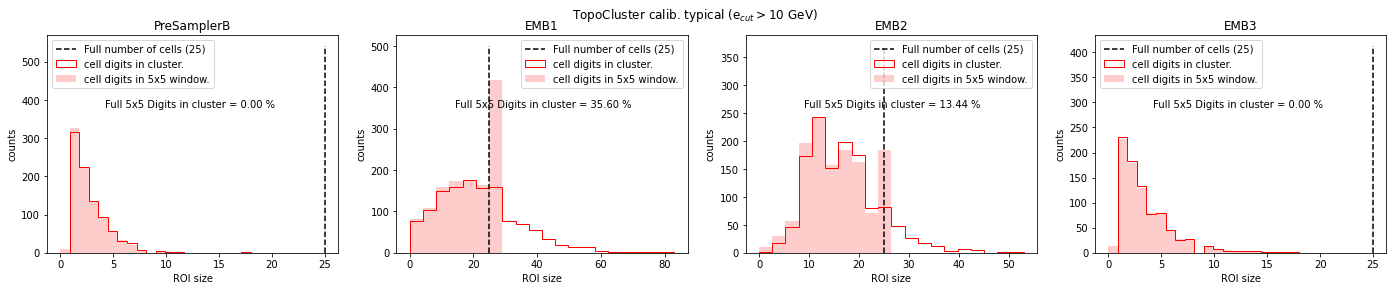

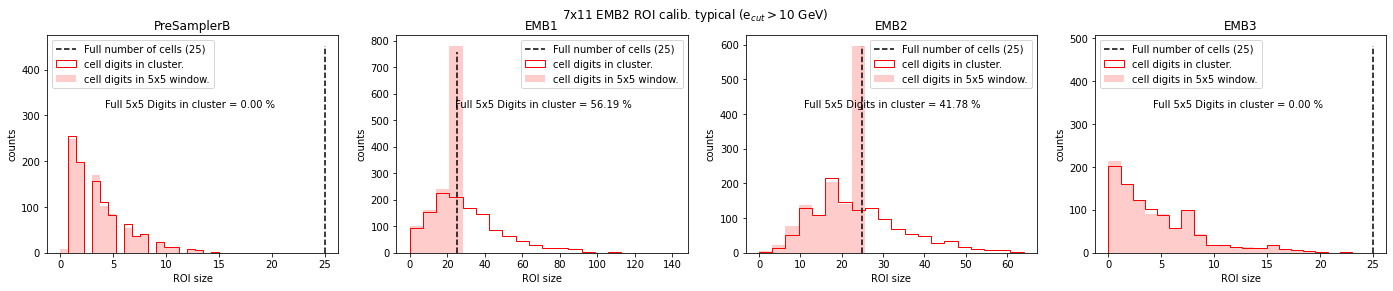

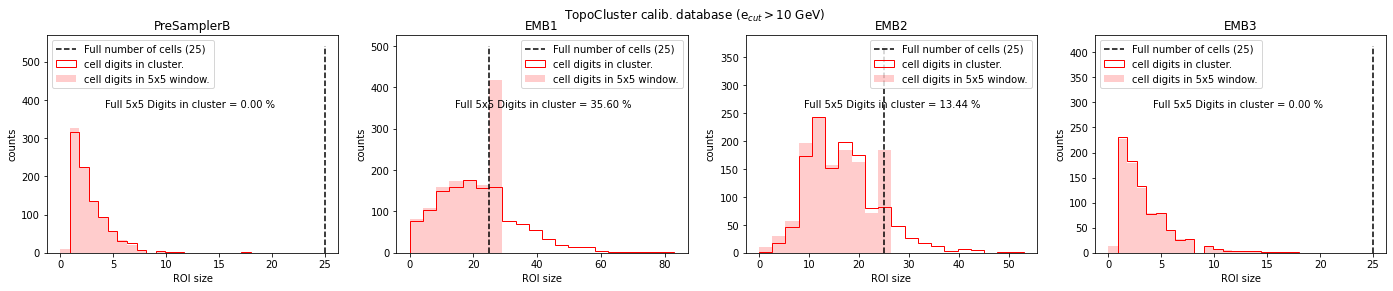

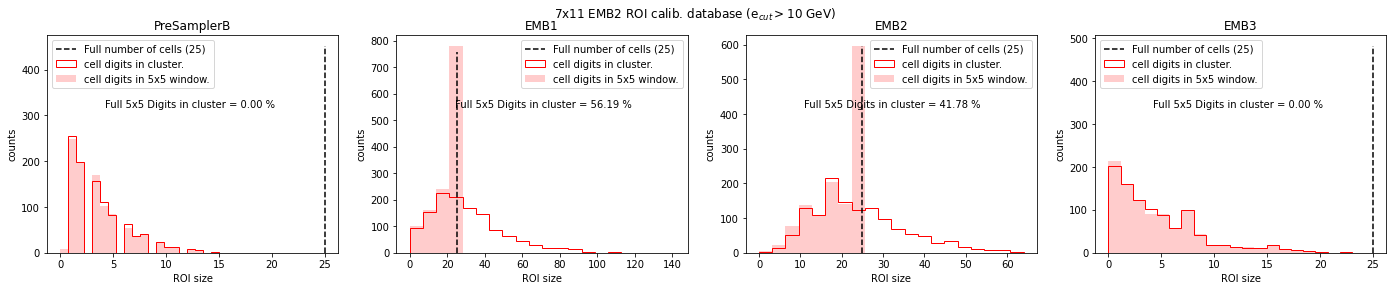

In [6]:

# -----------------------
# Digits collection size
# -----------------------
calibTypes  = ['typical', 'database']
el_thr      = 10 #GeV
# resultFileAlias = 'analysisOFCflipped'
# resultFileAlias   = 'flipped_timeThres'

for calibType in calibTypes:
    resultFiles = ['calibration/results_analysisOFC{}_clusters_{}_etCut{}.npz'.format(resultFileAlias, calibType, el_thr), 'calibration/results_analysisOFC{}_711_roi_{}_etCut{}.npz'.format(resultFileAlias, calibType, el_thr)]
    supTitleString = ['TopoCluster', '7x11 EMB2 ROI']
    confFiles = ['calibration/conf_analysisOFC{}_clusters_{}_etCut{}.npz'.format(resultFileAlias, calibType, el_thr),'calibration/conf_analysisOFC{}_711_roi_{}_etCut{}.npz'.format(resultFileAlias, calibType, el_thr)]
    clusNames = ['clusters', '711_roi']

    for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
        results     = np.load(file, allow_pickle=True)
        confDict    = np.load(confFile, allow_pickle=True)['conf']
        
        el_thr = confDict.tolist()['el_thr']
        nCellsChEta = confDict.tolist()['nCellsChEta']
        nCellsChPhi = confDict.tolist()['nCellsChPhi']
        nCellsRawChEta = confDict.tolist()['nCellsRawChEta']
        nCellsRawChPhi = confDict.tolist()['nCellsRawChPhi']
        
        plt.figure(figsize=(24,4))
        plt.suptitle(supTitle+' '+'calib. '+calibType+r' (e$_{cut} > $'+'{} GeV)'.format(el_thr))
        for i, sampl in enumerate( list(results.keys())[0:4] ):
            resultsInSampl = results[sampl].tolist()
            
            plt.subplot(1,4,i+1)
            minRange = 0
            maxRange = np.max(resultsInSampl['digitsClusterSize'])
            countsCl, _ = np.histogram(resultsInSampl['digitsClusterSize'])
            countsWi, _ = np.histogram(resultsInSampl['digitsWindowSize'])
            
            totalNumClusters = len(resultsInSampl['digitsClusterSize'])
            totalNumWindows  = len(resultsInSampl['digitsWindowSize'])
            # nClusForANN = np.sum([k >= 25 for k in resultsInSampl['digitsClusterSize']])
            nClusForANN = np.sum([k >= 25 for k in resultsInSampl['digitsClusterSize']])

            plt.hist(resultsInSampl['digitsClusterSize'],bins=20,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
            plt.hist(resultsInSampl['digitsWindowSize'],bins=20,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
            plt.plot([(nCellsRawChEta*nCellsRawChPhi), (nCellsRawChEta*nCellsRawChPhi)],[0,np.max([countsCl,countsWi])],'k--',label='Full number of cells ({})'.format(nCellsRawChEta*nCellsRawChPhi))
            plt.text(0.2, 0.67, "Full %dx%d Digits in cluster = %.2f %%"%(nCellsChEta,nCellsChPhi,100*nClusForANN/totalNumClusters), transform=plt.gca().transAxes)
        #     plt.hist(results[sampl]['rawChClusterSize'],bins=20,histtype='step',color='blue', label='cell raw channel in cluster.')
        #     plt.hist(results[sampl]['rawChWindowSize'],bins=20,alpha=0.2,color='blue', label='cell raw channel in {}x{} window.'.format(nCellsRawChEta,nCellsRawChPhi))
            plt.legend()
            plt.title(sampl)
            plt.xlabel("ROI size")
            plt.ylabel("counts")
    #     plt.yscale('log') 
    

## B) Calibration + Error
    - The 'E' and 'tau' values are calibrated inside the official Athena software. So, beside the fact that they are being stored inside files which has a 'calibType' tag, these variables has the same values.

In [15]:
# resultFileAlias = 'analysisOFCflipped'

psToNs          = 1000
calibTypes      = ['typical', 'database']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10]
## MUST INCLUDE HERE ERAWCH, ALLIGN WITH THE SAME CHANNELS FROM OFFLINE CELLS. (IDEA: TAKE ONLY THE FULL WINDOWS )
plotTypes       = ['E', 'EDSP', 'Ecalib','tau','tauDSP','taucalib', 'Ediff','EDSPdiff', 'taudiff','tauDSPdiff', 'EdiffPerc'] # 'taudiffPerc'] only channel data
layers          = caloDict['Layer'][0:4]
xbins           = 50

print("Results filename alias: "+resultFileAlias)

for layer in layers:
    plots_dict = {plotType:{} for plotType in plotTypes}
    print(layer+'...')
    for el_thr in el_thrs:
        # print('\t'+str(el_thr)+'...')
        for calibType in calibTypes:
            for clusName in clusNames:
                resultFile = 'calibration/results_analysisOFC{}_{}_{}_etCut{}.npz'.format(resultFileAlias,clusName,calibType, el_thr)
                
                results     = np.load(resultFile, allow_pickle=True)
            
                for subClusName in subClusNames:
                    
                    plotKeyName         = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,el_thr)
                    plotKeyNameAthena   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                    
                    # print('\t\t'+plotKeyName)

                    myLayerData = results[layer].tolist()

                    plots_dict['E'][plotKeyNameAthena]      = list(np.concatenate(  myLayerData['channelEnergy{}'.format(subClusName)]  ).flat)
                    plots_dict['EDSP'][plotKeyName]         = list(np.concatenate(  myLayerData['EDSPCalib{}'.format(subClusName)]      ).flat)
                    plots_dict['Ecalib'][plotKeyName]       = list(np.concatenate(  myLayerData['ECalib{}'.format(subClusName)]         ).flat)
                    plots_dict['tau'][plotKeyNameAthena]    = list(np.concatenate(  myLayerData['channelTime{}'.format(subClusName)]    ).flat)                # ns
                    plots_dict['tauDSP'][plotKeyName]       = [x/psToNs for x in list(np.concatenate(  myLayerData['tauDSP{}'.format(subClusName)]         ).flat)] # conversion from ps to ns
                    # plots_dict['taucalib'][plotKeyName]     = [x/psToNs for x in list(np.concatenate(  myLayerData['tau{}'.format(subClusName)]).flat)]     # conversion from ps to ns
                    plots_dict['taucalib'][plotKeyName]     = list(np.concatenate(  myLayerData['tau{}'.format(subClusName)]).flat)     # ns (offline)
                    plots_dict['Ediff'][plotKeyName]        = np.array(plots_dict['E'][plotKeyNameAthena])   - np.array(plots_dict['Ecalib'][plotKeyName])
                    plots_dict['EDSPdiff'][plotKeyName]     = np.array(plots_dict['E'][plotKeyNameAthena])   - np.array(plots_dict['EDSP'][plotKeyName])
                    plots_dict['taudiff'][plotKeyName]      = np.array(plots_dict['tau'][plotKeyNameAthena]) - np.array(plots_dict['taucalib'][plotKeyName])
                    plots_dict['tauDSPdiff'][plotKeyName]      = np.array(plots_dict['tau'][plotKeyNameAthena]) - np.array(plots_dict['tauDSP'][plotKeyName])
                    plots_dict['EdiffPerc'][plotKeyName]    = (plots_dict['Ediff'][plotKeyName]/plots_dict['E'][plotKeyNameAthena])*100
                    # plots_dict[layer]['taudiffPerc'][plotKeyName]   = (plots_dict[layer]['taudiff'][plotKeyName]/plots_dict[layer]['tau'][plotKeyName])*100

                    # ## Get the minimum energy of a cell that had its timing set as non-zero.
                    # eneList         = np.array(np.concatenate(  myLayerData['channelEnergy{}'.format(subClusName)]  ).flat)
                    # timeList        = np.array(np.concatenate(  myLayerData['channelTime{}'.format(subClusName)]).flat)

                    # NonZeroTimeCellsIndexes = np.where(np.abs(timeList) > 0)[0] 
                    # ZeroTimeCellsIndexes    = np.where(timeList == 0)[0] 
                    # NonZeroTimeCellsEnergy  = eneList[NonZeroTimeCellsIndexes]
                    # ZeroTimeCellsEnergy     = eneList[ZeroTimeCellsIndexes]
                    # E_thr_min               = np.min(NonZeroTimeCellsEnergy)
                    # E_thr_max               = np.max(ZeroTimeCellsEnergy)

    filename = 'calibration/plots_CalibAnalysis_{}.npz'.format(layer)
    np.savez(filename,**plots_dict)

Results filename alias: timeThres
PreSamplerB...
EMB1...
EMB2...
EMB3...


## C) Batch Plots
    - These codes below can be executed after generating the 'plots_CalibAnalysis_samplingName.npz'.
        - There will be all the combination of calibration plots.

### Analysis I: Comparison by **el_thr** cut

In [9]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

calibTypes      = ['typical', 'database']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
el_thrs         = [10] #GeV
plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc'] # 'taudiffPerc'] only channel data
xlabels         = ['Energy [MeV]', 'Energy [MeV]', 'Time [ns]','Time [ns]', 'Energy [MeV]','Time [ns]','Relative difference [%]']#,'Relative difference [%]']
colors          = ['blue','red', 'black', 'green']
layers          = caloDict['Layer'][0:4]
xbins           = 50


for i, layer in enumerate( layers ):
    print(layer+'...')
    plots_calib     = np.load('calibration/plots_CalibAnalysis_{}.npz'.format(layer), allow_pickle=True)

    for k, plotType in enumerate( plotTypes ):
        print('\tPlot type: '+plotType+'...')
        for calibType in calibTypes:
            for cli, clusName in enumerate( clusNames ):
                for subClusName in subClusNames:
                    supTitleString = ['TopoCluster: {}'.format(subClusName), '7x11 EMB2 ROI: {}'.format(subClusName)]

                    myFig = plt.figure(figsize=(6,4))

                    for j, el_thr in enumerate( el_thrs ):
                        if plotType == 'E' or plotType == 'tau':
                            plotKeyName             = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                            plotKeyNameForBinsRef   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',10)
                        else:
                            plotKeyName = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,el_thr)
                            plotKeyNameForBinsRef   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,10)
                        # plotKeyName             = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,el_thr)
                        # plotKeyNameAthena       = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                        # plotKeyNameForBinsRef   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,10)
                        
                        theBins     = np.histogram(plots_calib[plotType].tolist()[plotKeyNameForBinsRef],xbins)[1]
                        myPlot      = plots_calib[plotType].tolist()[plotKeyName]
                        plt.hist(myPlot,bins=theBins,histtype='step',color=colors[j], label='{} GeV cut'.format(el_thr), density=True)
                        
                    plt.legend()
                    if (plotType == 'E') or (plotType == 'tau'):
                        plt.title(layer+' - Calib: Athena')
                    else:
                        plt.title(layer+' - Calib: '+calibType)
                    plt.xlabel(xlabels[k])
                    plt.ylabel("counts")
                    plt.yscale('log')
                    if (plotType == 'E') or (plotType == 'tau'):
                        filename = 'calibration/calibPlots/analysis1_el_thr/{}_{}_{}_{}_{}.pdf'.format(layer, plotType, 'AthenaCalib', clusName, subClusName)
                        plt.savefig(filename)
                        # print('\t\t'+filename)
                    else:
                        filename = 'calibration/calibPlots/analysis1_el_thr/{}_{}_{}_{}_{}.pdf'.format(layer, plotType, calibType+'Calib', clusName, subClusName)
                        plt.savefig(filename)
                        # print('\t\t'+filename)
                        # break
                    plt.clf()
                    plt.close(myFig)
                    # plt.show()



# plots_dict[layer]['EdiffPerc']['clusters_Window_database_etCut15']

PreSamplerB...
	Plot type: E...
	Plot type: Ecalib...
	Plot type: tau...
	Plot type: taucalib...
	Plot type: Ediff...
	Plot type: taudiff...
	Plot type: EdiffPerc...
EMB1...
	Plot type: E...
	Plot type: Ecalib...
	Plot type: tau...
	Plot type: taucalib...
	Plot type: Ediff...
	Plot type: taudiff...
	Plot type: EdiffPerc...
EMB2...
	Plot type: E...
	Plot type: Ecalib...
	Plot type: tau...
	Plot type: taucalib...
	Plot type: Ediff...
	Plot type: taudiff...
	Plot type: EdiffPerc...
EMB3...
	Plot type: E...
	Plot type: Ecalib...
	Plot type: tau...
	Plot type: taucalib...
	Plot type: Ediff...
	Plot type: taudiff...
	Plot type: EdiffPerc...


### Analysis II: Comparison by **Calib. type**

In [9]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

calibTypes      = ['typical', 'database']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10]
# plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc', 'taudiffPerc'] # only channel data
plotTypes       = ['E', 'tau'] # only channel data
xlabels         = ['Energy [MeV]', 'Time [ns]']#,'Relative difference [%%]']
colors          = ['blue','red', 'black', 'green']
layers          = caloDict['Layer'][0:4]
yscales         = ['linear','log']
xbins           = 50
densityPlot     = False


for yscaleType in yscales:
    print('plot scale Y: '+yscaleType)
    for i, layer in enumerate( layers ):
        print(layer+'...')
        plots_calib     = np.load('calibration/plots_CalibAnalysis_{}.npz'.format(layer), allow_pickle=True)

        for k, plotType in enumerate( plotTypes ):
            print('\tPlot type: '+plotType+'...')
            # for calibType in calibTypes:
            for el_thr in el_thrs:
                for cli, clusName in enumerate( clusNames ):
                    for subClusName in subClusNames:
                        supTitleString = ['TopoCluster: {}'.format(subClusName), '7x11 EMB2 ROI: {}'.format(subClusName)]

                        myFig = plt.figure(figsize=(6,4))

                        # for j, calibType in enumerate(calibTypes):
                        plotKeyNameAthena       = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                        plotKeyNameTypical      = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'typical',el_thr)
                        plotKeyNameDatabase     = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'database',el_thr)
                        theBins                 = np.histogram(plots_calib[plotType+'calib'].tolist()[plotKeyNameTypical],xbins)[1]
                        
                        plt.hist(plots_calib[plotType].tolist()[plotKeyNameAthena],bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='Athena', density=densityPlot)
                        plt.hist(plots_calib[plotType+'calib'].tolist()[plotKeyNameTypical],bins=theBins,histtype='step',color=colors[1], label='Typical', density=densityPlot)
                        plt.hist(plots_calib[plotType+'calib'].tolist()[plotKeyNameDatabase],bins=theBins,histtype='step',color=colors[0], label='Database', density=densityPlot)
                            
                        plt.legend()
                        plt.title('{} calibration comparison '.format(xlabels[k][:-5])+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel(xlabels[k])
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)

                        filename = 'calibration/calibPlots/analysis2_calibType/{}_{}_cut{}GeV_{}_{}_yaxis{}.pdf'.format(layer, plotType, el_thr, clusName, subClusName, yscaleType)
                        plt.savefig(filename)
                        # print('\t\t'+filename)
                            # break
                        plt.clf()
                        plt.close(myFig)
                        # plt.show()



# plots_dict[layer]['EdiffPerc']['clusters_Window_database_etCut15']

plot scale Y: linear
PreSamplerB...
	Plot type: E...
	Plot type: tau...
EMB1...
	Plot type: E...
	Plot type: tau...
EMB2...
	Plot type: E...
	Plot type: tau...
EMB3...
	Plot type: E...
	Plot type: tau...
plot scale Y: log
PreSamplerB...
	Plot type: E...
	Plot type: tau...
EMB1...
	Plot type: E...
	Plot type: tau...
EMB2...
	Plot type: E...
	Plot type: tau...
EMB3...
	Plot type: E...
	Plot type: tau...


### Analysis III: Time x Energy relation

In [10]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

calibTypes      = ['typical', 'database']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10] #GeV
# plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc', 'taudiffPerc'] # only channel data
xlabels         = ['Cell Energy [MeV]', 'Cell Time [ns]']#,'Relative difference [%%]']
colors          = ['blue','red', 'black', 'green']
layers          = caloDict['Layer'][0:4]
yscales         = ['linear','log']
xscales         = ['linear','log']
xbins           = 50
densityPlot     = False


for xscaleType in xscales:
    print('plot scale X: '+xscaleType)
    for i, layer in enumerate( layers ):
        print(layer+'...')
        plots_calib     = np.load('calibration/plots_CalibAnalysis_{}.npz'.format(layer), allow_pickle=True)

        # for k, plotType in enumerate( plotTypes ):
        #     print('\tPlot type: '+plotType+'...')
            # for calibType in calibTypes:
        for el_thr in el_thrs:
            for cli, clusName in enumerate( clusNames ):
                for subClusName in subClusNames:
                    supTitleString = ['TopoCluster: {}'.format(subClusName), '7x11 EMB2 ROI: {}'.format(subClusName)]

                    # myFig = plt.figure(figsize=(6,4))
                    myFig = plt.figure(figsize=(16,7))

                    # for j, calibType in enumerate(calibTypes):
                    plotKeyNameAthena       = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                    plotKeyNameTypical      = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'typical',el_thr)
                    plotKeyNameDatabase     = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'database',el_thr)
                    # theBins                 = np.histogram(plots_calib[plotType+'calib'].tolist()[plotKeyNameTypical],xbins)[1]

                    xPlot1   = plots_calib['E'].tolist()[plotKeyNameAthena]
                    yPlot1   = plots_calib['tau'].tolist()[plotKeyNameAthena]
                    xPlot2   = plots_calib['Ecalib'].tolist()[plotKeyNameTypical]
                    yPlot2   = plots_calib['taucalib'].tolist()[plotKeyNameTypical]
                    xPlot3   = plots_calib['Ecalib'].tolist()[plotKeyNameDatabase]
                    yPlot3   = plots_calib['taucalib'].tolist()[plotKeyNameDatabase]

                    plt.subplot(1,3,1)
                    plt.scatter(xPlot1,yPlot1, marker='.',label='Athena',color='gray')
                    plt.grid()
                    plt.xlabel(xlabels[0])
                    plt.ylabel(xlabels[1])
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(1,3,2)
                    plt.scatter(xPlot2,yPlot2, marker='.',label='Typical',color=colors[1])
                    plt.grid()
                    plt.xlabel(xlabels[0])
                    plt.ylabel(xlabels[1])
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(1,3,3)
                    plt.scatter(xPlot3,yPlot3, marker='.',label='Database',color=colors[0])
                    plt.grid()
                    plt.xlabel(xlabels[0])
                    plt.ylabel(xlabels[1])
                    plt.legend()
                    plt.xscale(xscaleType)
                        
                    plt.suptitle('Calibration comparison '+layer+r' $e^{\pm}$$_{cut} =$'+' {}'.format(el_thr)+' GeV')

                    filename = 'calibration/calibPlots/analysis3_eneTime/eneTime_{}_cut{}GeV_{}_{}_xaxis{}.pdf'.format(layer,  el_thr, clusName, subClusName,xscaleType)
                    plt.savefig(filename)
                    plt.clf()
                    plt.close(myFig)


# plots_dict[layer]['EdiffPerc']['clusters_Window_database_etCut15']

plot scale X: linear
PreSamplerB...
EMB1...
EMB2...
EMB3...
plot scale X: log
PreSamplerB...
EMB1...
EMB2...
EMB3...


### Analysis IV: E x Ecalib + tau x taucalib

In [16]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

calibTypes      = ['typical', 'database']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10] #GeV
# plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc', 'taudiffPerc'] # only channel data
xlabels         = ['Cell Energy [MeV]', 'Cell Time [ns]']#,'Relative difference [%%]']
colors          = ['blue','red', 'black', 'green']
layers          = caloDict['Layer'][0:4]
yscales         = ['linear','log']
xscales         = ['linear']
xbins           = 50
densityPlot     = False


for xscaleType in xscales:
    print('plot scale X: '+xscaleType)
    for i, layer in enumerate( layers ):
        print(layer+'...')
        plots_calib     = np.load('calibration/plots_CalibAnalysis_{}.npz'.format(layer), allow_pickle=True)

        # for k, plotType in enumerate( plotTypes ):
        #     print('\tPlot type: '+plotType+'...')
            # for calibType in calibTypes:
        for el_thr in el_thrs:
            for cli, clusName in enumerate( clusNames ):
                for subClusName in subClusNames:
                    supTitleString = ['TopoCluster: {}'.format(subClusName), '7x11 EMB2 ROI: {}'.format(subClusName)]

                    # myFig = plt.figure(figsize=(6,4))
                    myFig = plt.figure(figsize=(20,10))

                    # for j, calibType in enumerate(calibTypes):
                    plotKeyNameAthena       = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                    plotKeyNameTypical      = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'typical',el_thr)
                    plotKeyNameDatabase     = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'database',el_thr)
                    # theBins                 = np.histogram(plots_calib[plotType+'calib'].tolist()[plotKeyNameTypical],xbins)[1]

                    Eath     = plots_calib['E'].tolist()[plotKeyNameAthena]
                    tauath   = plots_calib['tau'].tolist()[plotKeyNameAthena] 
                    # Etyp     = plots_calib['Ecalib'].tolist()[plotKeyNameTypical]  # offline
                    Etyp     = plots_calib['EDSP'].tolist()[plotKeyNameTypical] 
                    # tautyp   = plots_calib['taucalib'].tolist()[plotKeyNameTypical] # offline
                    tautyp   = plots_calib['tauDSP'].tolist()[plotKeyNameTypical]
                    # Edatab   = plots_calib['Ecalib'].tolist()[plotKeyNameDatabase] # offline
                    Edatab   = plots_calib['EDSP'].tolist()[plotKeyNameDatabase]
                    # taudatab = plots_calib['taucalib'].tolist()[plotKeyNameDatabase] # offline
                    taudatab = plots_calib['tauDSP'].tolist()[plotKeyNameDatabase] 

                    ## First row of plots
                    plt.subplot(2,3,1)
                    plt.scatter(Eath,Etyp, marker='.',label='Athena x Typical', color=[colors[0]])
                    plt.grid()
                    plt.xlabel(xlabels[0]+' (Athena)')
                    plt.ylabel(xlabels[0]+' (Typical)')
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(2,3,2)
                    plt.scatter(Eath,Edatab, marker='.',label='Athena x Database',color=colors[1])
                    plt.grid()
                    plt.xlabel(xlabels[0]+' (Athena)')
                    plt.ylabel(xlabels[0]+' (Database)')
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(2,3,3)
                    plt.scatter(Etyp,Edatab, marker='.',label='Typical x Database',color='gray')
                    plt.grid()
                    plt.xlabel(xlabels[0]+' (Typical)')
                    plt.ylabel(xlabels[0]+' (Database)')
                    plt.legend()
                    plt.xscale(xscaleType)

                    ## Second row of plots
                    plt.subplot(2,3,4)
                    plt.scatter(tauath,tautyp, marker='.',label='Athena x Typical', color=[colors[0]])
                    plt.grid()
                    plt.xlabel(xlabels[1]+' (Athena)')
                    plt.ylabel(xlabels[1]+' (Typical)')
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(2,3,5)
                    plt.scatter(tauath,taudatab, marker='.',label='Athena x Database',color=colors[1])
                    plt.grid()
                    plt.xlabel(xlabels[1]+' (Athena)')
                    plt.ylabel(xlabels[1]+' (Database)')
                    plt.legend()
                    plt.xscale(xscaleType)

                    plt.subplot(2,3,6)
                    plt.scatter(tautyp,taudatab, marker='.',label='Typical x Database',color='gray')
                    plt.grid()
                    plt.xlabel(xlabels[1]+' (Typical)')
                    plt.ylabel(xlabels[1]+' (Database)')
                    plt.legend()
                    plt.xscale(xscaleType)
                        
                    plt.suptitle('DSP Calibration comparison '+layer+r' $e^{\pm}$$_{cut} =$'+' {}'.format(el_thr)+' GeV')

                    filename = 'calibration/calibPlots/analysis4_eneTimeCalib/eneTimeCalib_{}_cut{}GeV_{}_{}_xaxis{}.png'.format(layer,  el_thr, clusName, subClusName,xscaleType)
                    plt.savefig(filename)
                    plt.clf()
                    plt.close(myFig)


# plots_dict[layer]['EdiffPerc']['clusters_Window_database_etCut15']

plot scale X: linear
PreSamplerB...
EMB1...
EMB2...
EMB3...


### Analysis V: Minimum E_thr for timing
Attempt to find the minimum cell energy that the timing estimation is applied in the Athena current (Run2) calibration chain. $$\tau = 0, E_{cell} < thr_{min}$$

In [7]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

psToNs          = 1 
calibTypes      = ['typical', 'database']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10]
# plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc'] # 'taudiffPerc'] only channel data
layers          = caloDict['Layer'][0:4]
colors          = ['blue','red', 'black', 'green']
xbins           = 100
densityPlot     = True
yscaleTypes     = ['log','linear']
textPositionX   = [0.5, 0.5]
textPositionY   = [0.67, 0.57]

print("Results filename alias: "+resultFileAlias)

for layer in layers:
    # plots_dict = {plotType:{} for plotType in plotTypes}
    print(layer+'...')
    for el_thr in el_thrs:
        # print('\t'+str(el_thr)+'...')
        for calibType in calibTypes:
            for clusName in clusNames:
                resultFile = 'calibration/results_analysisOFC{}_{}_{}_etCut{}.npz'.format(resultFileAlias,clusName,calibType, el_thr)
                
                results     = np.load(resultFile, allow_pickle=True)
            
                for subClusName in subClusNames:
                    
                    # plotKeyName         = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,el_thr)
                    # plotKeyNameAthena   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                    # print('\t\t'+plotKeyName)

                    myLayerData = results[layer].tolist()

                    ## Get the minimum energy of a cell that had its timing set as non-zero.
                    eneList         = np.array(np.concatenate(  myLayerData['channelEnergy{}'.format(subClusName)]).flat)
                    timeList        = np.array(np.concatenate(  myLayerData['channelTime{}'.format(subClusName)]).flat)

                    NonZeroTimeCellsIndexes = np.where(np.abs(timeList) > 0)[0] 
                    ZeroTimeCellsIndexes    = np.where(timeList == 0)[0] 
                    NonZeroTimeCellsEnergy  = eneList[NonZeroTimeCellsIndexes]
                    ZeroTimeCellsEnergy     = eneList[ZeroTimeCellsIndexes]
                    E_thr_min               = np.min(NonZeroTimeCellsEnergy)
                    E_thr_max               = np.max(ZeroTimeCellsEnergy)

                    # print(layer +',  Cut ' + str(el_thr) +  'GeV, ClusName '+clusName+ ', subClusName '+subClusName+':  min Cell Energy With |Time| > 0: '+str(E_thr_min)+' /  max cell energy with time == 0: '+str(E_thr_max))

                    for yscaleType in yscaleTypes:
                        myFig = plt.figure(figsize=(20,10))

                        theBins     = np.histogram(eneList,xbins)[1]

                        plt.suptitle('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        
                        ## First ROW
                        plt.subplot(2,2,1)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=False)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=False)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=False)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)                        
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('Energy [MeV]')
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)
                        # plt.grid()

                        plt.subplot(2,2,2)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=True)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=True)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=True)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('Energy [MeV]')
                        plt.ylabel("normalized counts")
                        plt.yscale(yscaleType)
                        # plt.grid()

                        ## Second ROW
                        plt.subplot(2,2,3)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=False)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=False)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=False)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('Energy [MeV]')
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)
                        plt.xscale('log')
                        # plt.grid()

                        plt.subplot(2,2,4)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=True)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=True)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=True)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('Energy [MeV]')
                        plt.ylabel("normalized counts")
                        plt.yscale(yscaleType)
                        plt.xscale('log')
                        # plt.grid()

                        filename = 'calibration/calibPlots/analysis5_timeThr/timeThr_{}_cut{}GeV_{}_{}_yaxis{}.pdf'.format(layer, el_thr, clusName, subClusName, yscaleType)
                        plt.savefig(filename)
                        plt.clf()
                        plt.close(myFig)

                    # plots_dict['E'][plotKeyNameAthena]      = list(np.concatenate(  myLayerData['channelEnergy{}'.format(subClusName)]  ).flat)
                    # plots_dict['Ecalib'][plotKeyName]       = list(np.concatenate(  myLayerData['ECalib{}'.format(subClusName)]         ).flat)
                    # plots_dict['tau'][plotKeyNameAthena]    = list(np.concatenate(  myLayerData['channelTime{}'.format(subClusName)]).flat)                # ns
                    # plots_dict['taucalib'][plotKeyName]     = [x/psToNs for x in list(np.concatenate(  myLayerData['tau{}'.format(subClusName)]).flat)]     # conversion from ps to ns
                    # plots_dict['Ediff'][plotKeyName]        = np.array(plots_dict['E'][plotKeyNameAthena])   - np.array(plots_dict['Ecalib'][plotKeyName])
                    # plots_dict['taudiff'][plotKeyName]      = np.array(plots_dict['tau'][plotKeyNameAthena]) - np.array(plots_dict['taucalib'][plotKeyName])
                    # plots_dict['EdiffPerc'][plotKeyName]    = (plots_dict['Ediff'][plotKeyName]/plots_dict['E'][plotKeyNameAthena])*100
                    # plots_dict[layer]['taudiffPerc'][plotKeyName]   = (plots_dict[layer]['taudiff'][plotKeyName]/plots_dict[layer]['tau'][plotKeyName])*100

    # filename = 'calibration/plots_CalibAnalysis_{}.npz'.format(layer)
    # np.savez(filename,**plots_dict)

Results filename alias: timeThres
PreSamplerB...
EMB1...
EMB2...
EMB3...


### Analysis VI: Minimum E_thr for RawCh timing
Attempt to find the minimum cell energy that the timing estimation is applied in the Athena current (Run2) calibration chain. $$\tau = 0, E^{DSP}_{cell} < thr_{min}$$

In [8]:
matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

psToNs          = 1 
calibTypes      = ['typical', 'database']
clusNames       = ['clusters', '711_roi']
subClusNames    = ['Cluster', 'Window']
# el_thrs         = [5,10,15,20] #GeV
el_thrs         = [10]
# plotTypes       = ['E', 'Ecalib','tau','taucalib', 'Ediff', 'taudiff', 'EdiffPerc'] # 'taudiffPerc'] only channel data
layers          = caloDict['Layer'][0:4]
colors          = ['blue','red', 'black', 'green']
xbins           = 100
densityPlot     = True
yscaleTypes     = ['log','linear']
textPositionX   = [0.5, 0.5]
textPositionY   = [0.67, 0.57]

print("Results filename alias: "+resultFileAlias)

for layer in layers:
    # plots_dict = {plotType:{} for plotType in plotTypes}
    print(layer+'...')
    for el_thr in el_thrs:
        # print('\t'+str(el_thr)+'...')
        for calibType in calibTypes:
            for clusName in clusNames:
                resultFile = 'calibration/results_analysisOFC{}_{}_{}_etCut{}.npz'.format(resultFileAlias,clusName,calibType, el_thr)
                
                results     = np.load(resultFile, allow_pickle=True)
            
                for subClusName in subClusNames:
                    
                    # plotKeyName         = '{}_{}_{}_etCut{}'.format(clusName,subClusName,calibType,el_thr)
                    # plotKeyNameAthena   = '{}_{}_{}_etCut{}'.format(clusName,subClusName,'Athena',el_thr)
                    # print('\t\t'+plotKeyName)

                    myLayerData = results[layer].tolist()

                    ## Get the minimum energy of a cell that had its timing set as non-zero.
                    eneList         = np.array(np.concatenate(  myLayerData['amplitude{}'.format(subClusName)]).flat)
                    timeList        = np.array(np.concatenate(  myLayerData['rawChTime{}'.format(subClusName)]).flat)

                    NonZeroTimeCellsIndexes = np.where(np.abs(timeList) > 0)[0] 
                    ZeroTimeCellsIndexes    = np.where(timeList == 0)[0] 
                    NonZeroTimeCellsEnergy  = eneList[NonZeroTimeCellsIndexes]
                    ZeroTimeCellsEnergy     = eneList[ZeroTimeCellsIndexes]
                    E_thr_min               = np.min(NonZeroTimeCellsEnergy)
                    E_thr_max               = np.max(ZeroTimeCellsEnergy)

                    # print(layer +',  Cut ' + str(el_thr) +  'GeV, ClusName '+clusName+ ', subClusName '+subClusName+':  min Cell Energy With |Time| > 0: '+str(E_thr_min)+' /  max cell energy with time == 0: '+str(E_thr_max))

                    for yscaleType in yscaleTypes:
                        myFig = plt.figure(figsize=(20,10))

                        theBins     = np.histogram(eneList,xbins)[1]

                        plt.suptitle('DSP time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        
                        ## First ROW
                        plt.subplot(2,2,1)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=False)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=False)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=False)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)                        
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('DSP Energy [MeV]')
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)
                        # plt.grid()

                        plt.subplot(2,2,2)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=True)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=True)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=True)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('DSP Energy [MeV]')
                        plt.ylabel("normalized counts")
                        plt.yscale(yscaleType)
                        # plt.grid()

                        ## Second ROW
                        plt.subplot(2,2,3)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=False)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=False)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=False)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('DSP Energy [MeV]')
                        plt.ylabel("counts")
                        plt.yscale(yscaleType)
                        plt.xscale('log')
                        # plt.grid()

                        plt.subplot(2,2,4)
                        plt.hist(eneList,bins=theBins,histtype='stepfilled',alpha=0.2,facecolor=colors[2],edgecolor='none', label='All cells. {} entries.'.format(len(eneList)), density=True)
                        plt.hist(NonZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[1], label='Non-zero time cells. {} entries.'.format(len(NonZeroTimeCellsEnergy)), density=True)
                        plt.hist(ZeroTimeCellsEnergy,bins=theBins,histtype='step',color=colors[0], label='Zero time cells. {} entries.'.format(len(ZeroTimeCellsEnergy)), density=True)
                        plt.text(textPositionX[0], textPositionY[0], "$E^{thr}_{min}$ = %.2f MeV"%(np.min(NonZeroTimeCellsEnergy)), color='r', transform=plt.gca().transAxes)
                        plt.text(textPositionX[1], textPositionY[1], "$E^{thr}_{max}$ = %.2f MeV"%(np.max(ZeroTimeCellsEnergy)), color='b', transform=plt.gca().transAxes)
                        plt.legend()
                        # plt.title('Athena time calibration '+layer+r' $e^{\pm}$$_{cut} =$'+' {} GeV'.format(el_thr))
                        plt.xlabel('DSP Energy [MeV]')
                        plt.ylabel("normalized counts")
                        plt.yscale(yscaleType)
                        plt.xscale('log')
                        # plt.grid()

                        filename = 'calibration/calibPlots/analysis6_rawTimeThr/rawTimeThr_{}_cut{}GeV_{}_{}_yaxis{}.pdf'.format(layer, el_thr, clusName, subClusName, yscaleType)
                        plt.savefig(filename)
                        plt.clf()
                        plt.close(myFig)

                    # plots_dict['E'][plotKeyNameAthena]      = list(np.concatenate(  myLayerData['channelEnergy{}'.format(subClusName)]  ).flat)
                    # plots_dict['Ecalib'][plotKeyName]       = list(np.concatenate(  myLayerData['ECalib{}'.format(subClusName)]         ).flat)
                    # plots_dict['tau'][plotKeyNameAthena]    = list(np.concatenate(  myLayerData['channelTime{}'.format(subClusName)]).flat)                # ns
                    # plots_dict['taucalib'][plotKeyName]     = [x/psToNs for x in list(np.concatenate(  myLayerData['tau{}'.format(subClusName)]).flat)]     # conversion from ps to ns
                    # plots_dict['Ediff'][plotKeyName]        = np.array(plots_dict['E'][plotKeyNameAthena])   - np.array(plots_dict['Ecalib'][plotKeyName])
                    # plots_dict['taudiff'][plotKeyName]      = np.array(plots_dict['tau'][plotKeyNameAthena]) - np.array(plots_dict['taucalib'][plotKeyName])
                    # plots_dict['EdiffPerc'][plotKeyName]    = (plots_dict['Ediff'][plotKeyName]/plots_dict['E'][plotKeyNameAthena])*100
                    # plots_dict[layer]['taudiffPerc'][plotKeyName]   = (plots_dict[layer]['taudiff'][plotKeyName]/plots_dict[layer]['tau'][plotKeyName])*100

    # filename = 'calibration/plots_CalibAnalysis_{}.npz'.format(layer)
    # np.savez(filename,**plots_dict)

Results filename alias: timeThres
PreSamplerB...
EMB1...
EMB2...
EMB3...


In [5]:
myLayerData.keys()

dict_keys(['digitsCluster', 'digitsWindow', 'digitsClusterSize', 'digitsWindowSize', 'channelEnergyCluster', 'channelEnergyWindow', 'channelTimeCluster', 'channelTimeWindow', 'channelInfoCluster', 'channelInfoWindow', 'channelIdCluster', 'channelIdWindow', 'channelGainCluster', 'channelGainWindow', 'Acluster', 'tauCluster', 'Awindow', 'tauWindow', 'ECalibCluster', 'ECalibWindow', 'amplitudeCluster', 'amplitudeWindow', 'rawChTimeCluster', 'rawChTimeWindow', 'rawChInfoCluster', 'rawChInfoWindow', 'rawChIdCluster', 'rawChIdWindow', 'rawChGainCluster', 'rawChGainWindow'])

In [ ]:
# calibTypes = ['typical', 'database']
# el_thr      = 10 #GeV

# for calibType in calibTypes:
#     resultFiles = ['calibration/results_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr), 'calibration/results_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
#     supTitleString = ['TopoCluster', '7x11 EMB2 ROI']
#     confFiles = ['calibration/conf_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr),'calibration/conf_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
#     clusNames = ['clusters', '711_roi']


        
#     for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
#         results     = np.load(file, allow_pickle=True)
#         confDict    = np.load(confFile, allow_pickle=True)['conf']
        
#         el_thr = confDict.tolist()['el_thr']
#         nCellsChEta = confDict.tolist()['nCellsChEta']
#         nCellsChPhi = confDict.tolist()['nCellsChPhi']
#         nCellsRawChEta = confDict.tolist()['nCellsRawChEta']
#         nCellsRawChPhi = confDict.tolist()['nCellsRawChPhi']
        
        
#         # ---------------------------
#         # Channel collection size Calib Energy
#         # ---------------------------

#         xbins = 50
#         plt.figure(figsize=(24,4))
#         plt.suptitle(supTitle)
#         for i, layer in enumerate( list(results.keys())[0:4] ):
#             resultsInSampl = results[layer].tolist()

#             plt.subplot(1,4,i+1)
            
#             allClusters = [list(np.concatenate(resultsInSampl['ECalibCluster']).flat), list(np.concatenate(resultsInSampl['channelEnergyCluster']).flat)]
#             theBins     = plt.hist(allClusters[0],bins=xbins,histtype='step',color='blue', label='cell calib. energy in cluster (outside Athena)')
#             plt.hist(allClusters[1],bins=theBins[1],histtype='step',color='red', label='cell calib. energy in cluster.')
            
#             plt.legend()
#             plt.title(layer+' - Calib: '+calibType)
#             plt.xlabel("Energy [MeV]")
#             plt.ylabel("counts")
#         #     plt.xscale('log')
#             # plt.yscale('log')

#         # ---------------------------
#         # RawChannel collection size Calib DIFFERENCE Energy
#         # ---------------------------
#         xbins = 50
#         plt.figure(figsize=(24,4))
#         plt.suptitle(supTitle+' - Calib: '+calibType)
#         for i, layer in enumerate( list(results.keys())[0:4] ):
#             resultsInSampl = results[layer].tolist()
            
#             plt.subplot(1,4,i+1)
               
#             calibDiffE = np.concatenate(resultsInSampl['channelEnergyWindow']).flat[0:-1] - np.concatenate(resultsInSampl['ECalibWindow']).flat[0:-1]
#             plt.hist(calibDiffE,bins=xbins,histtype='step',color='black', label='cell calib. diff. energy in sub-cluster.')

#             plt.legend()
#             plt.title(layer)
#             plt.xlabel(r'E_{Athena} - E_{calib} \[MeV\]')
#             plt.ylabel("counts")
#             # plt.xscale('log')
#             plt.yscale('log')

#             # plt.hist(calibDiffE,bins=xbins,histtype='step',color='black', label='cell calib. diff energy in  sub-cluster.')
#         #     plt.hist(calibDiffEperc,bins=xbins,histtype='step',color='black', label='cell calib. diff energy in %% sub-cluster.')

#         # ---------------------------
#         # Channel collection size Calib DIFFERENCE Tau
#         # ---------------------------
#         xbins = 50
#         plt.figure(figsize=(24,4))
#         plt.suptitle(supTitle+' - Calib: '+calibType)
#         for i, layer in enumerate( list(results.keys())[0:4] ):
#             resultsInSampl = results[layer].tolist()

#             plt.subplot(1,4,i+1)
            
#             calibDiffTau        = np.concatenate(resultsInSampl['channelTimeWindow']).flat[0:-1] - np.concatenate(resultsInSampl['tauWindow']).flat[0:-1]
#             plt.hist(calibDiffTau,bins=xbins,histtype='step',color='green', label='cell calib. diff time in  sub-cluster.')

#             plt.legend()
#             plt.title(layer)
#             plt.xlabel(r'\tau_{Athena} - \tau_{calib} \[ns\]')
#             plt.ylabel("counts")
#             # plt.xscale('log')
#             plt.yscale('log')



In [ ]:
resultsInSampl.keys()

In [ ]:
nSamples = -1
# print(list(np.concatenate(resultsInSampl['channelEnergyWindow']).flat)[0:nSamples],'\n', list(np.concatenate(resultsInSampl['channelIdWindow']).flat)[0:nSamples])
# print(list(np.concatenate(resultsInSampl['ECalibWindow']).flat)[0:nSamples],'\n', list(np.concatenate(resultsInSampl['channelIdWindow']).flat)[0:nSamples])
print(np.concatenate(resultsInSampl['ECalibWindow']).flat[0:nSamples] - np.concatenate(resultsInSampl['channelEnergyWindow']).flat[0:nSamples])

# print(resultsInSampl['channelEnergyWindow'][0:nSamples],'\n', resultsInSampl['channelIdWindow'][0:nSamples])
# print(resultsInSampl['ECalibWindow'][0:nSamples],'\n', resultsInSampl['channelIdWindow'][0:nSamples])
# print(resultsInSampl['ECalibWindow'][0:nSamples][0] - resultsInSampl['channelEnergyWindow'][0:nSamples][0])

## Subplots with error

In [ ]:
calibTypes = ['typical', 'database']
el_thr      = 10 #GeV

for calibType in calibTypes:
    resultFiles = ['calibration/results_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr), 'calibration/results_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
    supTitleString = ['TopoCluster', '7x11 EMB2 ROI']
    confFiles = ['calibration/conf_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr),'calibration/conf_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
    clusNames = ['clusters', '711_roi']


        
    for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
        results     = np.load(file, allow_pickle=True)
        confDict    = np.load(confFile, allow_pickle=True)['conf']
        
        el_thr = confDict.tolist()['el_thr']
        nCellsChEta = confDict.tolist()['nCellsChEta']
        nCellsChPhi = confDict.tolist()['nCellsChPhi']
        nCellsRawChEta = confDict.tolist()['nCellsRawChEta']
        nCellsRawChPhi = confDict.tolist()['nCellsRawChPhi']
        
        
        # ---------------------------
        # RawChannel collection size Calib
        # ---------------------------

        xbins = 100

        for i, layer in enumerate( list(results.keys())[0:4] ):
            if layer!='EMB2':
                continue
            resultsInSampl = results[layer].tolist()

            allClusters = [list(np.concatenate(resultsInSampl['ECalibCluster']).flat), list(np.concatenate(resultsInSampl['channelEnergyCluster']).flat)] # flat results list
            theBins         = np.histogram(allClusters[0],bins=xbins) # get bins array
            theBinsAthena   = np.histogram(allClusters[1],bins=theBins[1]) # get bins array
            
            # plt.subplot(1,4,i+1)
            # f, (a0,a1) = plt.subplots(2,1, gridspec_kw={'height_ratios': [5, 1]},figsize=(13,10))
            f, (a0,a1) = plt.subplots(2,2, gridspec_kw={'width_ratios': [5,1], 'height_ratios': [5,1], 'hspace': 0.4, 'wspace': 0.25},figsize=(9,6))
            
            a0[0].hist(allClusters[0],bins=xbins,histtype='step',color='blue', label='cell calib. energy in cluster (outside Athena)')
            a0[0].hist(allClusters[1],bins=theBins[1],histtype='step',color='red', label='cell calib. energy in cluster.')
            a0[0].legend()
            a0[0].set_title(supTitle+ ' - ' +layer+' - Calib: '+calibType)
            a0[0].set_xlabel("Energy [MeV]")
            a0[0].set_ylabel("counts")

            a0[1].hist(theBins[0] - theBinsAthena[0],bins=xbins,orientation='horizontal',histtype='stepfilled',facecolor='gray',edgecolor='black', label='cell calib. diff energy in cluster.')
            a0[1].set_title("Calib. error\nhistogram")
            a0[1].set_ylabel("Energy [MeV]")
            a0[1].set_xlabel("counts")
            a0[1].set_xscale('log')

            a1[0].plot(theBins[1][1:], (theBins[0] - theBinsAthena[0]), 'o')
            a1[0].set_title("Difference / bin")
            a1[0].grid()

            a1[1].set_visible(False)
            

In [ ]:
calibTypes = ['typical', 'database']
for calibType in calibTypes:
    resultFiles = ['calibration/results_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr), 'calibration/results_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
    supTitleString = ['TopoCluster', '7x11 EMB2 ROI']
    confFiles = ['calibration/conf_analysisOFC_clusters_{}_etCut{}.npz'.format(calibType, el_thr),'calibration/conf_analysisOFC_711_roi_{}_etCut{}.npz'.format(calibType, el_thr)]
    clusNames = ['clusters', '711_roi']


        
    for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
        print(supTitle + ' ' + calibType)

        results     = np.load(file, allow_pickle=True)
        confDict    = np.load(confFile, allow_pickle=True)['conf']

        # print(list(results.keys()))
        # print(results['PreSamplerB'].tolist().keys())
        # print(np.shape(results['PreSamplerB'].tolist()['digitsCluster']))
        # print(results['EMB2'].tolist()['digitsCluster'])
        # print('from here!!!!')
        # print(results['EMB2'].tolist()['digitsWindow'])

        # for cl, win in zip(results['EMB2'].tolist()['digitsCluster'], results['EMB2'].tolist()['digitsWindow']):
        #     print(len(cl), len(win))
        #     if (len(cl) != len(win)):
        #         print('Cluster and window have different sizes!')







# Machine Learning

In [ ]:
import tensorflow as tf
from tensorflow import keras

## Dataset split
- Training + validation
- Test

In [ ]:
##################
# Dataset counter
##################

evt_counter     = 0
ele_counter     = 0
ele_ec_counter  = 0
clu_ec_counter  = 0
clu_counter     = 0
clusName        = '711_roi'
datasetPath     ='/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias_janFix/dataMinBias_janFix_part*.npz'
fileNames       = glob(datasetPath)

for file in fileNames:
    dataset     = np.load(file, allow_pickle=True)

    for evtn, ev in enumerate(dataset['dataset']): # for each event...
        evt_counter+=1

        for elecn, elec in enumerate(ev['electrons'].keys()): # for each electron in this event...

            # if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
            #     continue
            if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                # continue
                ele_ec_counter+=1
                clusloop = ev['electrons'][elec][clusName]
                for clusn, clus in enumerate(clusloop.keys()): # for each cluster associated to that electron...
                    clu_ec_counter+=1
            else:
                ele_counter+=1
                clusloop = ev['electrons'][elec][clusName]
                for clusn, clus in enumerate(clusloop.keys()): # for each cluster associated to that electron...
                    clu_counter+=1

print("Dataset counter in Barrel:\n\t Events: {}\n\t Electrons: {}\n\t Clusters ({}): {}".format(evt_counter, ele_counter,clusName,clu_counter))
print("Dataset counter in EC:\n\t Events: {}\n\t Electrons: {}\n\t Clusters ({}): {}".format(evt_counter, ele_ec_counter,clusName,clu_ec_counter))

###############
# Splitting dataset
###############
split_ratio         = 0.7 # nTrain/nTest
nCellsChEta         = 5 # window size of sub-cluster, in cell number
nCellsChPhi         = 5
nCellsRawChEta      = 5
nCellsRawChPhi      = 5
clusNames           = ['711_roi', 'clusters'] #'clusters'
cellInfoNames       = ['channels','rawChannels']
calibType           = 'database'#'database' #'typical' # or 

dataset_train       = {}
dataset_test        = {}
ele_train_counter   = 0
ele_test_counter    = 0


for file in fileNames:
    dataset     = np.load(file, allow_pickle=True)
    
    for evtn, ev in enumerate(dataset['dataset']): # for each event...
        # evt_counter+=1
        for elecn, elec in enumerate(ev['electrons'].keys()): # for each electron in this event...

            # if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
            #     continue
            if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                continue

            else:
                ## Copy electron content to new subset, with new global set electron key.
                selected_electron = {}
                for ele_key in ev['electrons'][elec].keys():
                    selected_electron.update({ele_key: ev['electrons'][elec][ele_key] })
                    
                for clusName in clusNames:
                    for clus in selected_electron[clusName].keys(): # for each cluster associated to that electron (the cluster is a key)
                        for layern, layer in enumerate(caloDict["Layer"][0:4]):
                            for cellInfoName in cellInfoNames:
                                # if layer=='EMB2':
                                
                                ###################
                                ## Channel + RawChannels
                                ###################

                                ## Create trimmed cluster with samples, for selected Layer/Sampling
                                if cellInfoName=='rawChannels':
                                    energy='amplitude'
                                else:
                                    energy='energy'

                                windowIndexesCh, layerIndexesCh = getCellsInWindowCustomSize(
                                    selected_electron[clusName][clus][cellInfoName][energy],
                                    selected_electron[clusName][clus][cellInfoName]['index'],
                                    selected_electron[clusName][clus][cellInfoName]['eta'],
                                    selected_electron[clusName][clus][cellInfoName]['phi'],
                                    selected_electron[clusName][clus][cellInfoName]['sampling'],
                                    nCellsChEta, 
                                    nCellsChPhi, 
                                    selected_electron[clusName][clus][cellInfoName]['deta'],
                                    selected_electron[clusName][clus][cellInfoName]['dphi'],
                                    layer=layer)

                                    # create new 55_711_roi and 55_cluster (its a copy with different indexes.)
                                selected_electron[clusName][clus][cellInfoName].update( {'{}{}{}_{}'.format(nCellsChEta,nCellsChPhi,layer,clusName): windowIndexesCh} )
                                selected_electron[clusName][clus][cellInfoName].update( {'{}_{}'.format(layer,clusName): layerIndexesCh} )

                                ## Batch Variables:
                                #   - Time spread over a batch of 'batchSize'

                
                        # print(selected_electron[clusName][clus]['channels'].keys())
                            # if layer == 'EMB2':
                            #     print(clusName+': ',len(np.array(selected_electron[clusName][clus][cellInfoName]['sampling'][0],dtype=object)[layerIndexesCh]), np.array(selected_electron[clusName][clus][cellInfoName]['sampling'][0],dtype=object)[layerIndexesCh])

                ## Split electrons into train and test sub sets
                if ele_train_counter < round(ele_counter*split_ratio):              
                    dataset_train.update({'el_{}'.format(ele_train_counter):selected_electron})                
                    ele_train_counter+=1
                else:
                    dataset_test.update({'el_{}'.format(ele_test_counter):selected_electron})                
                    ele_test_counter+=1


#####################
# Batch Variables
# #####################
# batchSize       = 20 # number of samples to build the batch variables

# # for clusName in clusNames:
#     # subClusterBatchTime     = {key: [] for key in caloDict["Layer"][0:4]}
#     # clusterBatchTime        = {key: [] for key in caloDict["Layer"][0:4]}

# timeInBatch = []

# for evtn, el in enumerate(dataset_train.keys()):
#     dataset_train[el]
#     if evtn % batchSize == 0:
#         #add mean and std of time to all events

#     for cl in dataset_train[el][clusName]:
#             for lay in caloDict["Layer"][0:4]:
#                 # print(dataset_train[l]['711_roi'].keys())
#                 subClusterSize[lay].append(len(dataset_train[el][clusName][cl][cellInfoName]['55{}_{}'.format(lay,clusName)]))
#                 clusterSize[lay].append(len(dataset_train[el][clusName][cl][cellInfoName]['{}_{}'.format(lay,clusName)]))






In [ ]:
#####################
# Vectorize inputs
# ###################

# take electrons clusters of samples, that are equal to the 5x5 window (that are just a fraction of them).
# this will return an equal size dataset of cluster cells.
# pack them in a new dictionary, with only the desired variables:
#   - samples
#   - chid
#   - gain
#   - sampling
#   - etaCell
#   - phiCell
# the new dict must have a matrix form (numpy array or list), which each column is an event, and its lines are the cluster cells, followed by its digits.
# the order of the array must obey a logical numbering, that can be reproducible and captured by the network the same way, for every input cluster.

datasetKeys     = [
'nevents',
'cellNameIndex', 
'samplesNameIndex', 
'eta', 
'phi', 
'samples',
'chid', 
'sampling', 
'gain', 
'time', 
'energy']
x_train         = {keyLabel: [] for keyLabel in datasetKeys}
x_test          = {keyLabel: [] for keyLabel in datasetKeys}
cellInfoName    = 'channels'
clusNames       =  ['711_roi']
layer           = caloDict['Layer'][2] # just EMB2 for now!!


## Training dataset
for el in dataset_train.keys():
    for clusName in clusNames:
        for cl in dataset_train[el][clusName].keys():            
            keyName = '{}{}{}_{}'.format(nCellsChEta, nCellsChPhi, layer, clusName) #keyName of the subCluster
            if len(dataset_train[el][clusName][cl][cellInfoName][keyName]) == (nCellsChEta * nCellsChPhi): # select only full subclusters (5x5)
                # sort the cluster cells
                subClusterIndexes   = dataset_train[el][clusName][cl][cellInfoName][keyName] # 5x5 subClusters

                etaCell             = np.array(dataset_train[el][clusName][cl][cellInfoName]['eta'][0],dtype=object)[subClusterIndexes]
                phiCell             = np.array(dataset_train[el][clusName][cl][cellInfoName]['phi'][0],dtype=object)[subClusterIndexes]
                samples             = np.array(dataset_train[el][clusName][cl][cellInfoName]['digits'][0],dtype=object)[subClusterIndexes]
                chid                = np.array(dataset_train[el][clusName][cl][cellInfoName]['channelId'][0],dtype=object)[subClusterIndexes]
                sampling            = np.array(dataset_train[el][clusName][cl][cellInfoName]['sampling'][0],dtype=object)[subClusterIndexes]
                gain                = np.array(dataset_train[el][clusName][cl][cellInfoName]['gain'][0],dtype=object)[subClusterIndexes]
                timeCell            = np.array(dataset_train[el][clusName][cl][cellInfoName]['time'][0],dtype=object)[subClusterIndexes]
                eneCell             = np.array(dataset_train[el][clusName][cl][cellInfoName]['energy'][0],dtype=object)[subClusterIndexes]

                orderedIndexes      = getSortedClusterIndexes(etaCell,phiCell)
                
                # desired variables to ML Training
                cellNameIndex       = []
                samplesNameIndex    = []
                etaList             = []
                phiList             = []
                samplesList         = []
                chidList            = []
                samplingList        = []
                gainList            = []
                timeList            = []
                eneList             = []

                for cell in range(0,nCellsChEta*nCellsChPhi):

                    cellNameIndex.append('c{}'.format(cell))
                    etaList.append(etaCell[orderedIndexes][cell])
                    phiList.append(phiCell[orderedIndexes][cell])
                    chidList.append(chid[orderedIndexes][cell])                    
                    samplingList.append(sampling[orderedIndexes][cell])
                    gainList.append(gain[orderedIndexes][cell])
                    timeList.append(timeCell[orderedIndexes][cell])
                    eneList.append(eneCell[orderedIndexes][cell])

                    for s in range(0,4):
                        samplesNameIndex.append('c{}_s{}'.format(cell,s))
                        samplesList.append(samples[orderedIndexes][cell][s])
                
                # add data to main dataset dict
                x_train['cellNameIndex'].append(cellNameIndex)
                x_train['samplesNameIndex'].append(samplesNameIndex)
                x_train['eta'].append(etaList)
                x_train['phi'].append(phiList)
                x_train['samples'].append(samplesList)
                x_train['chid'].append(chidList)
                x_train['sampling'].append(samplingList)
                x_train['gain'].append(gainList)
                x_train['time'].append(timeList)
                x_train['energy'].append(eneList)

            else:
                continue
x_train['nevents'].append(len(x_train['samples']))

# ----------------------------------------------------------------------------------------------------------------------------------------------

## Test dataset
for el in dataset_test.keys():
    for clusName in clusNames:
        for cl in dataset_test[el][clusName].keys():            
            keyName = '{}{}{}_{}'.format(nCellsChEta, nCellsChPhi, layer, clusName) #keyName of the subCluster
            if len(dataset_test[el][clusName][cl][cellInfoName][keyName]) == (nCellsChEta * nCellsChPhi): # select only full subclusters (5x5)
                # sort the cluster cells
                subClusterIndexes   = dataset_test[el][clusName][cl][cellInfoName][keyName] # 5x5 subClusters

                etaCell             = np.array(dataset_test[el][clusName][cl][cellInfoName]['eta'][0],dtype=object)[subClusterIndexes]
                phiCell             = np.array(dataset_test[el][clusName][cl][cellInfoName]['phi'][0],dtype=object)[subClusterIndexes]
                samples             = np.array(dataset_test[el][clusName][cl][cellInfoName]['digits'][0],dtype=object)[subClusterIndexes]
                chid                = np.array(dataset_test[el][clusName][cl][cellInfoName]['channelId'][0],dtype=object)[subClusterIndexes]
                sampling            = np.array(dataset_test[el][clusName][cl][cellInfoName]['sampling'][0],dtype=object)[subClusterIndexes]
                gain                = np.array(dataset_test[el][clusName][cl][cellInfoName]['gain'][0],dtype=object)[subClusterIndexes]
                timeCell            = np.array(dataset_test[el][clusName][cl][cellInfoName]['time'][0],dtype=object)[subClusterIndexes]
                eneCell             = np.array(dataset_test[el][clusName][cl][cellInfoName]['energy'][0],dtype=object)[subClusterIndexes]

                orderedIndexes      = getSortedClusterIndexes(etaCell,phiCell)
                
                # desired variables to ML Training
                cellNameIndex       = []
                samplesNameIndex    = []
                etaList             = []
                phiList             = []
                samplesList         = []
                chidList            = []
                samplingList        = []
                gainList            = []
                timeList            = []
                eneList             = []

                for cell in range(0,nCellsChEta*nCellsChPhi):

                    cellNameIndex.append('c{}'.format(cell))
                    etaList.append(etaCell[orderedIndexes][cell])
                    phiList.append(phiCell[orderedIndexes][cell])
                    chidList.append(chid[orderedIndexes][cell])                    
                    samplingList.append(sampling[orderedIndexes][cell])
                    gainList.append(gain[orderedIndexes][cell])
                    timeList.append(timeCell[orderedIndexes][cell])
                    eneList.append(eneCell[orderedIndexes][cell])

                    for s in range(0,4):
                        samplesNameIndex.append('c{}_s{}'.format(cell,s))
                        samplesList.append(samples[orderedIndexes][cell][s])
                
                # add data to main dataset dict
                x_test['cellNameIndex'].append(cellNameIndex)
                x_test['samplesNameIndex'].append(samplesNameIndex)
                x_test['eta'].append(etaList)
                x_test['phi'].append(phiList)
                x_test['samples'].append(samplesList)
                x_test['chid'].append(chidList)
                x_test['sampling'].append(samplingList)
                x_test['gain'].append(gainList)
                x_test['time'].append(timeList)
                x_test['energy'].append(eneList)

            else:
                continue
x_test['nevents'].append(len(x_test['samples']))

In [ ]:
# print((np.array(samplesList).reshape(100,1)[0]))
# print(samples[orderedIndexes])
# print(cellNameIndex)
# print(chidList)
# np.array(dataset_train[el][clusName][cl][cellInfoName]['energy'][0])[orderedIndexes]
# len(dataset_train[el][clusName][cl][cellInfoName]['eta'][0])
# x_train
# print(type(chidList))
# print(type(chid))
print(len(x_train['energy'])/len(dataset_train.keys()),len(x_test['energy'])/len(dataset_test.keys()))

# print(dataset_train[el][clusName][cl][cellInfoName].keys())
# print(etaCell,phiCell)
# print(len(etaCell[orderedIndexes]),phiCell[orderedIndexes])
# plt.plot(etaCell[orderedIndexes],phiCell[orderedIndexes],'.')
# plt.yscale('log')

In [ ]:
# for el in dataset_train.keys():
#     for cl in dataset_train[el]['711_roi']
#     dataset_train[el]
# dataset_train['el_0']['711_roi']['cl_0']['channels']['eta'][0]
# caloDict['Layer'][2]
x = [0, 2, 4, 1, 0,0,0,1,1,2,2,3,3,3]
y = [4, 2, 3, 0, 1,2,2,3,3,4,4,0,0,1]
z = [ [a,b] for a,b in zip(x,y)]
# print(z)

def sortXY(z):
    my_list = np.array(z)
    ind = np.lexsort((my_list[:,0], my_list[:,1])) 
    sortedList = my_list[ind]
    # print(sortedList)
    # print(ind)
    # return ind
    return sortedList

def getSortedClusterIndexes(eta,phi):
    '''Return the indexes of an organized sequence of pairs of eta,phi, following a line from the smallest phi's, then the smallest eta's. '''
    ind = np.lexsort((eta,phi)) 
    return ind

def sortEtaPhiCluster(my_list):
    sortedList = sorted(my_list , key=lambda k: [k[1], k[0]])
    # print(sortedList)
    return sortedList

ind = getSortedClusterIndexes(x,y)
# print(ind)
# print(z)
print(np.array(z)[ind])

print(np.array(z)[ind] - sortEtaPhiCluster(z))

In [ ]:
my_list = [[1,2],[0,2],[2,1],[1,1],[2,2],[2,0],[0,1],[1,0],[0,0]]
orderedList = sorted(my_list , key=lambda k: [k[1], k[0]])


In [ ]:
# selected_electron.keys()
# dataset_train['el_0']['clusters']['cl_0']['channels'].keys()

# subClusterIndex = []
cellInfoName = 'channels'#'rawChannels'

for clusName in clusNames:
    subClusterSize = {key: [] for key in caloDict["Layer"][0:4]}
    clusterSize = {key: [] for key in caloDict["Layer"][0:4]}
    for el in dataset_train.keys():
        # print(len(dataset_train[l]['711_roi'].keys()))
        for cl in dataset_train[el][clusName]:
            for lay in caloDict["Layer"][0:4]:
                # print(dataset_train[l]['711_roi'].keys())
                subClusterSize[lay].append(len(dataset_train[el][clusName][cl][cellInfoName]['55{}_{}'.format(lay,clusName)]))
                clusterSize[lay].append(len(dataset_train[el][clusName][cl][cellInfoName]['{}_{}'.format(lay,clusName)]))
                # subClusterIndex.append(dataset_train[l][clusName][cl]['channels']['55{}_{}'.format(lay,clusName)])
                # dataset_train['el_0']['711_roi']['cl_0']['channels']['index']
    # windowIndexesCh
    for lay in caloDict["Layer"][0:4]:
        plt.figure()
        counts, bin_edges = np.histogram(clusterSize[lay], bins=40)
        plt.hist(subClusterSize[lay],range=(0,max(clusterSize[lay])),bins=bin_edges, histtype='stepfilled',alpha=0.3,label='sub cluster')
        plt.hist(clusterSize[lay],bins=bin_edges,range=(0,max(clusterSize[lay])), histtype='step', color='black',label='cluster')
        plt.title(clusName+' '+lay+' '+cellInfoName)
        plt.legend()
        plt.show()
# for lay in caloDict["Layer"][0:4]:
#     plt.figure()
#     plt.hist(clusterSize[lay])
#     plt.title(clusName+' '+lay)
#     plt.show()
# plt.figure()
# plt.hist(subClusterIndex)
# plt.show()
# d1 = {'a':[0,1]}
# print(d1)
# d1.update({'b':[2,3]})
# print(d1)
# d1['b'].append(4)
# print(d1)

## NN setup

In [ ]:
# y_true      = np.array([0]) # time spread
digits_hat      = np.array([700, 990, 800, 880]) #  saida da rede


def e1_sumTau_loss(digits_hat, []): # add variables to the input
            
    # calculate loss, using y_pred
    Aclus, tauClus_hat, ECalClus = getCalibEnergyCellsFromSamplesInCluster(
                            chid,
                            digits_hat,
                            gainInt,
                            sampling,
                            etaCell ,
                            ofc_dict,
                            ped_dict,
                            mpmc_dict,
                            ramps_dict,
                            uamev_dict,
                            calibType
                    )
    e1_sumTaus = 0
    for tau in tauClus_hat:
        e1_sumTaus = e1_sumTaus + (tau - np.mean(tauClus_hat))**2
        
    return e1_sumTaus

def e2_samplesDiff_loss(digits, digits_hat, chids, ped_dict): # add gainInt

    e2_sampleDiff = 0

    for dig_meas, dig_pred, chid in zip(digits, digits_hat, chids): #a vector 4*25 for the event
        channel_dict_ped = getLArChannelPED(chid, ped_dict)
        sampleDiff = 0

        for s_meas, s_pred in zip(dig_meas, dig_pred):
            sampleDiff = sampleDiff + (s_meas - s_pred)**2/channel_dict_ped['rms']
            
        e2_sampleDiff = e2_sampleDiff + sampleDiff
    
    return e2_sampleDiff


def custom_loss(e1,e2,e3):

    loss = e1 + e2 + e3

    return loss


# model.compile(loss=custom_loss, optimizer='adam')

In [ ]:
# dataset_train.keys()
## NN configuration
Neur                = 5
inputShape          = 4*5*5 # nsamples * netaCells * nphiCells
actFun1             = 'relu'
actFun2             = 'linear'
redLR               = True
patienceEarlyStop   = 10

#################################################

init_weights = keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)

model = keras.Sequential([
    # keras.layers.Input(shape=(7,)),  # input layer (1) - possui 7 nós, devido à janela de sinal disponível.
    keras.layers.InputLayer(input_shape=(inputShape, )),
    keras.layers.Dense(Neur,
                        activation=actFun1,
                        kernel_initializer=init_weights,
                        bias_initializer='zeros'),  # hidden layer (2.0)
    keras.layers.Dense(inputShape,
                        activation=actFun2,
                        kernel_initializer=init_weights,
                        bias_initializer='zeros')  # output layer (3)
])

e1 = e1_sumTau_loss(digits_hat, []): # add variables to the input
e2 = ...
e3 = ...
myLoss = custom_loss(e1,e2,e3)

#otimizando o modelo
model.compile(
    optimizer='Adam',
    loss=custom_loss,
)

#treinando o modelo
#Com isso eu faco o meu criterio de parada ser a respeito da metrica loss,
#se a loss nao diminuir em 3 epocas - paro! (Evita o overtrainning).
#Ainda restaura os melhores pesos.
if redLR:
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=patienceEarlyStop,
        min_lr=0.001)
else:
    reduce_lr = []

callback = keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=patienceEarlyStop,
                                            restore_best_weights=True)



#Passam-se os dados, épocas máxima, tamanho conj. validação e critério de parada.
# model.fit(X_train, Y_train, epochs=15,validation_split=0.2, callbacks=[callback])
model.fit(
    X_train,
    Y_train,
    epochs=maxEpochs,
    validation_split=0.2,
    batch_size=batchSize,
    verbose=mostrarTreino,
    callbacks=[callback, reduce_lr])



In [ ]:
model.weights[3]

In [ ]:
## NN configuration
Neur    = 5
actFun1 = 'relu'
actFun2 = 'linear'

############################
# modelo da rede neural
init_weights = keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)
# init_weights = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

model = keras.Sequential([
    # keras.layers.Input(shape=(7,)),  # input layer (1) - possui 7 nós, devido à janela de sinal disponível.
    keras.layers.InputLayer(input_shape=(7, )),
    keras.layers.Dense(Neur,
                        activation=actFun1,
                        kernel_initializer=init_weights,
                        bias_initializer='zeros'),  # hidden layer (2.0)
    keras.layers.Dense(1,
                        activation=actFun2,
                        kernel_initializer=init_weights,
                        bias_initializer='zeros')  # output layer (3)
])
# print(model.get_weights)
#otimizando o modelo
model.compile(
    optimizer='Adam',
    loss='mse',
)

#treinando o modelo
#Com isso eu faco o meu criterio de parada ser a respeito da metrica loss,
#se a loss nao diminuir em 3 epocas - paro! (Evita o overtrainning).
#Ainda restaura os melhores pesos.
if redLR:
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=patienceEarlyStop,
        min_lr=0.001)
else:
    reduce_lr = []
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=patienceEarlyStop,
                                            restore_best_weights=True)

#Passam-se os dados, épocas máxima, tamanho conj. validação e critério de parada.
# model.fit(X_train, Y_train, epochs=15,validation_split=0.2, callbacks=[callback])
model.fit(X_train,
            Y_train,
            epochs=maxEpochs,
            validation_split=0.2,
            batch_size=batchSize,
            verbose=mostrarTreino,
            callbacks=[callback, reduce_lr])

# avaliando o modelo
test_loss = model.evaluate(X_test, Y_test, verbose=1)

#Fazendo a previsao:
outNetwork = model.predict(X_test) * calibOutput
eNetwork = outNetwork - Y_test * calibOutput
rmse = metrics.mean_squared_error(Y_test * calibOutput,
                                    outNetwork,
                                    squared=False)  #calcula o RMSE
stdNetwork = np.std(eNetwork)